In [ ]:
using Pkg
Pkg.add("DSP")

In [526]:
using Revise
using AD_GS
import Equilibrium
using Plots
using Optim
using LinearAlgebra

symmetric=true
diverted=true
δ = 0.7
ϵ = 0.32
κ = 1.9
B0 = 2.0
R0 = 1.8
qstar = 1.54
alpha = -0.155

symmetric=false
diverted=true
ϵ = 0.32
κ = 1.7
δ = 0.33
R0 = 6.2
B0 = 5.3
ip = 15.E6
alpha = -0.002

# symmetric=true
# diverted=true
# δ = -0.7
# ϵ = 0.32
# κ = 1.9
# B0 = 2.0
# R0 = 1.7
# qstar = 1.57
# alpha = -0.155

# symmetric=true
# diverted=true
# δ = -0.0
# ϵ = 0.32
# κ = 2.1
# B0 = 2.0
# R0 = 1.7
# qstar = 1.57
# alpha = -0.155

# symmetric=true
# diverted=false
# δ = -0.0
# ϵ = 0.32
# κ = 1.0
# B0 = 2.0
# R0 = 1.7
# qstar = 1.57
# alpha = .9

S = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar, B0_dir=1,Ip_dir=1,diverted=diverted,symmetric=symmetric)
S0 = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar,B0_dir=1,Ip_dir=1,diverted=false,symmetric=true)

dx=0.3
xlim, ylim = Equilibrium.limits(S)
xlim=(maximum([0,minimum(xlim)-(xlim[2]-xlim[1])*dx]),maximum(xlim)+(xlim[2]-xlim[1])*dx)
ylim=(minimum(ylim)-(ylim[2]-ylim[1])*dx,maximum(ylim)+(ylim[2]-ylim[1])*dx);

S

SolovevEquilibrium
  B0 = 5.3 [T]
  R0 = 6.2 [m]
  ϵ  = 0.32
  δ  = 0.33
  κ  = 1.7
  α  = -0.002
  q⋆ = 1.54
  βp = 0.9123481522041648
  βt = 0.03939300505384824
  σ  = 1
  diverted  = true
  symmetric = false

In [534]:
using StaticArrays
using PolygonOps
using Interpolations
using Contour

resolution=257
r = range(xlim[1]-dx,xlim[2]+dx,length=resolution)
z = range(ylim[1]-dx,ylim[2]+dx,length=resolution*Int(round((ylim[2]-ylim[1]/(xlim[2]-xlim[1])))))
pts = [((kr,kz),(rr,zz)) for (kz,zz) in enumerate(z), (kr,rr) in enumerate(r)]

dst = zeros(size(pts)...).+1

# domain
pr_outer=[xlim[1],xlim[2],xlim[2],xlim[1],xlim[1]]
pz_outer=[ylim[2],ylim[2],ylim[1],ylim[1],ylim[2]]
for ((kr,kz),(rr,zz)) in hcat(pts...)
    point = SA[rr,zz]
    if PolygonOps.inpolygon((rr,zz), StaticArrays.SVector.(pr_outer, pz_outer)) == 1
        dst[kz,kr] = 0
    end
end

# plasma distance
ψ0, ψb = Equilibrium.psi_limits(S0)
Psi0 = [S0(rr,zz) for (kz,zz) in enumerate(z), (kr,rr) in enumerate(r)]
Psi=Psi0.-dst*1E1
#display(Plots.contour(r,z,Psi0,levels=[(ψb)]))#,xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal))
cl = Contour.contour(z,r,Psi,(ψb-ψ0)*0.999+ψ0)
pr=nothing
pz=nothing
for line in Contour.lines(cl)
    pz, pr = Contour.coordinates(line)
    # ignore flux surfaces that do not close
    if !((pr[1] == pr[end]) & (pz[1] == pz[end]))
        continue
    end
    # only consider flux surfaces that contain magnetic axis
    if PolygonOps.inpolygon(((xlim[2]+xlim[1])/2,(ylim[2]+ylim[1])/2), StaticArrays.SVector.(pr, pz)) == 1
        break
    end
end

ml=1.2
pr_inner=(pr.-S0.R0).*ml.+S0.R0
pz_inner=pz.*ml*1.1

ml=ml+0.1
pr_coil=(pr.-S0.R0).*ml.+S0.R0
pz_coil=pz.*ml*1.1

for ((kr,kz),(rr,zz)) in hcat(pts...)
    point = SA[rr,zz]
    if PolygonOps.inpolygon((rr,zz), StaticArrays.SVector.(pr_inner, pz_inner)) == 1
        dst[kz,kr] = 1
    end
end

using DSP
n=7
filter=exp.(-(range(-1,1,length=2*n+1)/n).^2)
filter=filter./sum(filter)
dst=DSP.conv(filter,filter,dst)[n+1:end-n,n+1:end-n]

#display(heatmap(r,z,dst,xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal))
tmp = Interpolations.extrapolate(Interpolations.interpolate((z, r), dst, Interpolations.Gridded(Interpolations.Linear())),Interpolations.Flat());
dst_log_interpolant_raw = Interpolations.CubicSplineInterpolation((z, r), log10.(1.0.+dst))
dst_log_interpolant_raw = Interpolations.extrapolate(dst_log_interpolant_raw.itp,Interpolations.Flat());
function dst_log_interpolant(z,r)
    return 10.0.^(dst_log_interpolant_raw(z,r)).-1
end;

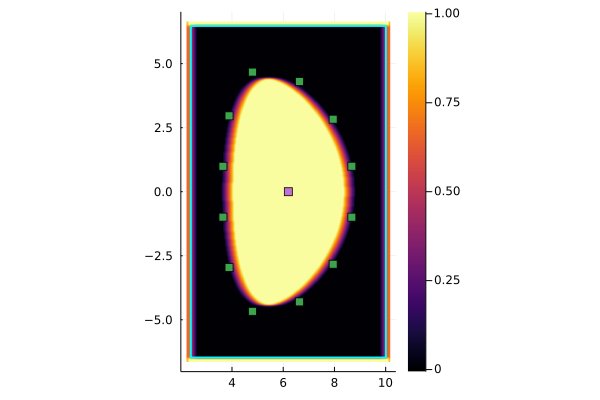

In [610]:
r = range(xlim[1]-dx/2.,xlim[2]+dx/2.,length=201)
z = range(ylim[1]-dx/2.,ylim[2]+dx/2.,length=Int(ceil(201*S0.kappa)))
dst=dst_log_interpolant(z,r)
heatmap(r,z,dst,xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal)
#plot!(pr_inner,pz_inner,lw=2,color=:magenta,label="")
plot!(pr_outer,pz_outer,lw=2,color=:cyan,label="")

ncoils = 12

using Random
using DSP
coils=[]
discarded_coils = []
if false
    while length(coils)<ncoils
        rp=rand()*(xlim[2]-xlim[1])+xlim[1]
        zp=rand()*(ylim[2]-ylim[1])+ylim[1]
        if dst_log_interpolant.(zp,rp)==0
            if symmetric
                push!(coils,(rp,abs(zp)))
                push!(coils,(rp,-abs(zp)))
            else
                push!(coils,(rp,zp))
            end
        else
            push!(discarded_coils,(rp,zp))
        end
    end
else
    θ_coil=atan.(pz_coil,pr_coil.-S0.R0)
    θ_coil=DSP.unwrap(θ_coil)
    if θ_coil[2]<θ_coil[1]
        θ_coil=-θ_coil
    end
    pr_coilθ=Interpolations.extrapolate(Interpolations.interpolate((θ_coil,), pr_coil, Interpolations.Gridded(Interpolations.Linear())),Interpolations.Periodic())
    pz_coilθ=Interpolations.extrapolate(Interpolations.interpolate((θ_coil,), pz_coil, Interpolations.Gridded(Interpolations.Linear())),Interpolations.Periodic())

    θ=range(0,2π,length=1001)[1:end-1]
    l2p=vcat(0,cumsum(sqrt.(diff(pr_coilθ(θ)).^2.0.+diff(pz_coilθ(θ)).^2.0)))
    lcoils=range(0,l2p[end],length=ncoils+1)[1:end-1]
    pr_coilL=Interpolations.extrapolate(Interpolations.interpolate((l2p,), pr_coilθ(θ), Interpolations.Gridded(Interpolations.Linear())),Interpolations.Periodic())
    pz_coilL=Interpolations.extrapolate(Interpolations.interpolate((l2p,), pz_coilθ(θ), Interpolations.Gridded(Interpolations.Linear())),Interpolations.Periodic())
    if mod(ncoils,2)==0
        f(x)=abs.(pz_coilL.(lcoils[1].+x).+pz_coilL.(lcoils[end].+x))[1]
    else
        f(x)=abs.(pz_coilL.(lcoils[1].+x))[1]
    end
    L0 = Optim.minimizer(Optim.optimize(f, 0.0, l2p[end]))
    coils=[[pr_coilL(L),pz_coilL(L)] for L in lcoils.+L0]
    if mod(ncoils,2)==1
        coils[1][2]=0.0
    end
end

#coils=coils_D3D_points;

λ_regularize0 = 1E-13

function pack(coils, λ_regularize)
    coilz = vcat([c[1] for c in coils if ((! symmetric) || c[2]>=0)],[c[2] for c in coils if ((! symmetric) || c[2]>=0)])
    packed = vcat(coilz, log10(λ_regularize))
    return packed
end
function unpack(packed)
    coilz = packed[1:end-1]
    λ_regularize = packed[end]
    coils =  [(coilz[k],coilz[k+Int(length(coilz)/2)]) for (k,c) in enumerate(coilz[1:Int(end/2)])]
    if S.symmetric
        coils = vcat(coils,[(c[1],-c[2]) for c in coils if c[2]!=0])
    end
    return coils, 10^λ_regularize
end

packed = pack(coils, λ_regularize0)
(coils, λ_regularize) = unpack(packed)
coils0 = coils

plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label="")
plot!([S0.R0],[0],markershape=:rect,lw=0,label="")
display(plot!([c[1] for c in discarded_coils],[c[2] for c in discarded_coils],markershape=:cross,lw=0,label=""))#,xlim=[r[1],r[end]],ylim=[z[1],z[end]], aspect_ratio=:equal))

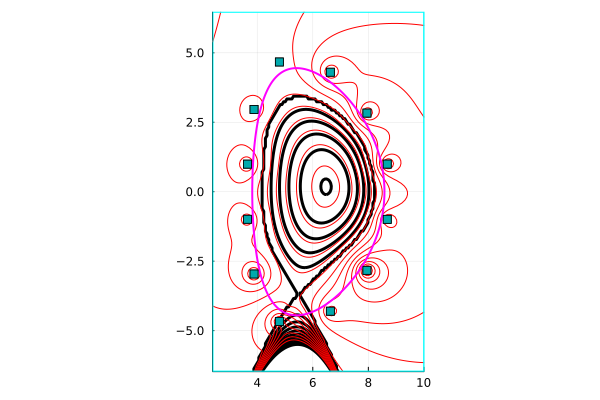

  0.419233 seconds (55.11 k allocations: 48.494 MiB)
 * Status: failure (exceeded time limit of 30.0)

 * Candidate solution
    Final objective value:     8.201424e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   30  (vs limit 30)
    Iterations:    5933
    f(x) calls:    7723



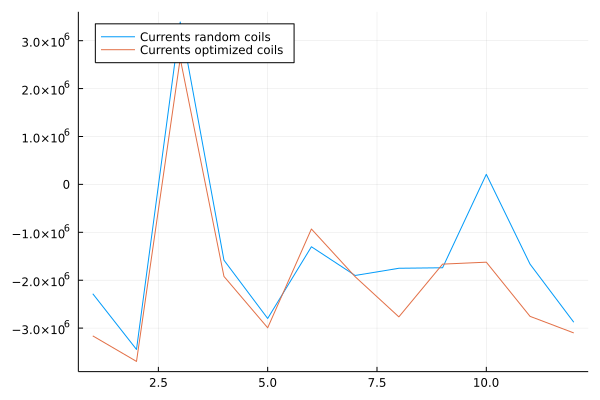

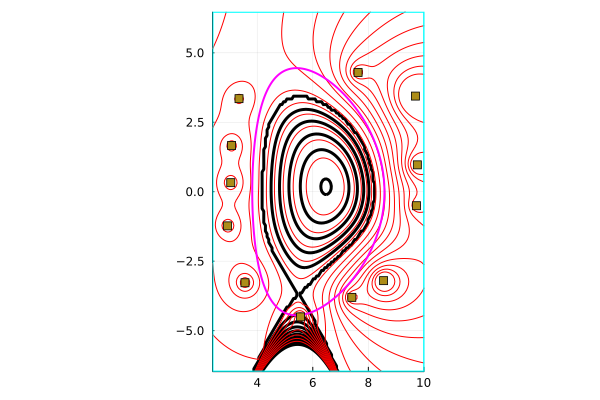

  0.417183 seconds (55.21 k allocations: 48.470 MiB)
λ_regularize = 6.3161992080602024e-24


In [611]:
coils = coils0
λ_regularize = λ_regularize0

@time currents0,cost0 = fixed_eq_currents(S,coils0,λ_regularize=λ_regularize,λ_minimize=0.0, λ_zerosum=0.0, return_cost=true)
check_fixed_eq_currents(S,coils0,currents0,resolution=129, Rmin=xlim[1], Rmax=xlim[2], Zmin=ylim[1], Zmax=ylim[2])
plot!([c[1] for c in coils0],[c[2] for c in coils0],markershape=:rect,lw=0,label="")
plot!(pr_inner, pz_inner, lw=2, color=:magenta,label="")
plot!(pr_outer, pz_outer, lw=2, color=:cyan,label="")
display(plot!([c[1] for c in coils0],[c[2] for c in coils0],markershape=:rect,lw=0,label=""))

function optimize_coils(S, coils, λ_regularize, ψp_cost_norm, currents_cost_norm, mask_interpolant)
    fixed_eq = ψp_on_fixed_eq_boundary(S)
    packed = pack(coils, λ_regularize)
    
    trace = Dict(:coils=>[],:currents=>[],:λ_regularize=>[],:cost_ψ=>[],:cost_currents=>[],:cost_bound=>[],:cost=>[])
    packed_tmp=[]
    function placement_cost(packed;do_trace=false)
        push!(packed_tmp, packed)
        (coils, λ_regularize) = unpack(packed)
        currents, cost = currents_to_match_ψp(fixed_eq...,coils, λ_regularize=λ_regularize, λ_minimize=0.0, λ_zerosum=0.0, return_cost=true)
        cost_ψ=cost/ψp_cost_norm
        cost_currents=norm(currents)/length(currents)/currents_cost_norm
        cost_bound=norm(mask_interpolant.([c[2] for c in coils],[c[1] for c in coils]))
        cost = sqrt.(cost_ψ.^2 + cost_currents.^2 + cost_bound.^2)
        if do_trace
            push!(trace[:currents],currents)
            push!(trace[:coils],coils)
            push!(trace[:λ_regularize],λ_regularize)
            push!(trace[:cost_ψ],cost_ψ)
            push!(trace[:cost_currents],cost_currents)
            push!(trace[:cost_bound],cost_bound)
            push!(trace[:cost],cost)
        end
        return cost
    end

    function clb(x)
        placement_cost(packed_tmp[end];do_trace=true)
        false
    end
    
    # use NelderMead() ; other optimizer that works is Newton(), others have trouble
    res = Optim.optimize(placement_cost, packed, Optim.NelderMead(), Optim.Options(time_limit=30,iterations=10000,allow_f_increases=true,successive_f_tol = 100, callback=clb); autodiff=:forward)
    packed = Optim.minimizer(res)
    (coils, λ_regularize) = unpack(packed)
    println(res)

    return coils, λ_regularize, trace
end

(coils, λ_regularize, trace) = optimize_coils(S, coils, λ_regularize, cost0, 1E7, dst_log_interpolant)

plot(currents0,label="Currents random coils", legend=:topleft)
@time currents = fixed_eq_currents(S, coils, λ_regularize=λ_regularize, λ_minimize=0.0, λ_zerosum=0.0, verbose=true)
display(plot!(currents,label="Currents optimized coils", legend=:topleft))

check_fixed_eq_currents(S,coils,currents,resolution=129, Rmin=xlim[1], Rmax=xlim[2], Zmin=ylim[1], Zmax=ylim[2])
plot!(pr_inner, pz_inner, lw=2, color=:magenta,label="")
plot!(pr_outer, pz_outer, lw=2, color=:cyan,label="")
display(plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label=""))

@show(λ_regularize);

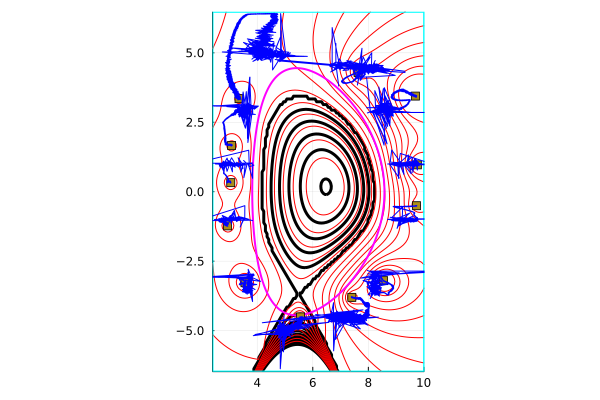

In [612]:
using ForwardDiff
function no_Dual(x)
    if typeof(x) <: ForwardDiff.Dual
        x = x.value
        return no_Dual(x)
    else
        return x
    end
end

for c in 1:length(trace[:coils][1])
    if c==1
        fplot=plot!
    elseif c==length(trace[:coils][1])
        fplot(args...;kw...)=display(plot!(args...;kw...))
    else
        fplot=plot!
    end
    fplot([no_Dual(k[c][1]) for k in trace[:coils]],[no_Dual(k[c][2]) for k in trace[:coils]],label="",color=:blue, lw=1)
end

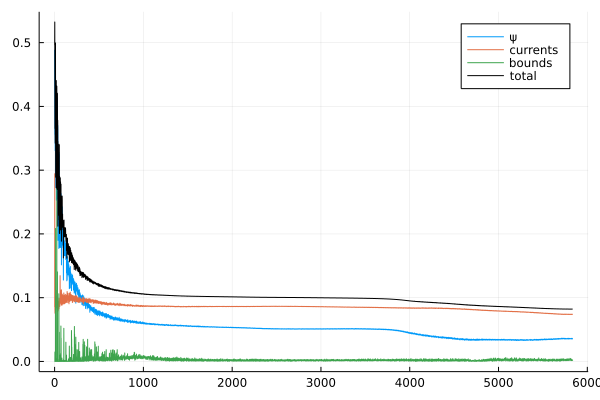

In [613]:
b=100
plot([no_Dual(x) for x in trace[:cost_ψ][b:end]],yscale=:identity,label="ψ")
plot!([no_Dual(x) for x in trace[:cost_currents][b:end]],yscale=:identity,label="currents")
plot!([no_Dual(x) for x in trace[:cost_bound][b:end]],yscale=:identity,label="bounds")
display(plot!([no_Dual(x) for x in trace[:cost][b:end]],yscale=:identity,label="total",color=:black))

LoadError: Cannot convert Matrix{Transpose{Float64, Vector{Float64}}} to series data for plotting